In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.backends.cudnn as cudnn

import time
import os
import copy
import cv2
import random

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
path_to_models = '/content/'

In [ ]:
def train_model(model, criterion, optimizer, data_loaders,
                batch_size, num_epochs=30):
  start_time = time.time()

  train_acc_history = []
  val_acc_history = []

  best_model_over_epochs = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs - 1))

    # Train and validate over each epoch
    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()  # Set model to training mode
      else:
        model.eval()   # Set model to evaluate mode

      batch_loss = 0.0
      batch_correct_preds = 0

      # Iterate over data
      for inputs, labels in tqdm(data_loaders[phase]):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          # Get model outputs and calculate loss
          if phase == 'train':
              outputs, aux_outputs = model(inputs)
              loss1 = criterion(outputs, labels)
              loss2 = criterion(aux_outputs, labels)
              loss = loss1 + 0.4*loss2
          else:
              outputs = model(inputs)
              loss = criterion(outputs, labels)

          _, preds = torch.max(outputs, 1)
          
          # Backward + Optimize only in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()
        
        batch_loss += loss.item() * inputs.size(0)
        batch_correct_preds += torch.sum(preds == labels.data)
      
      epoch_loss = batch_loss / len(data_loaders[phase].dataset)
      epoch_acc = batch_correct_preds.double() / len(data_loaders[phase].dataset)

      print('-' * 50)
      print('{} Loss: {:.4f}  Acc: {:.4f}\n\n'.format(phase,
                                                      epoch_loss,
                                                      epoch_acc))

      # Deep copy the model
      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_over_epochs = copy.deepcopy(model.state_dict())
      
      if phase == 'val':
        val_acc_history.append(epoch_acc)
      else:
        train_acc_history.append(epoch_acc)

  time_elapsed = time.time() - start_time
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60,
                                                      time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  # Load best model weights
  model.load_state_dict(best_model_over_epochs)
  
  # Save best model weights
  torch.save(model.state_dict(), path_to_models + f'model_weights_epoch-{num_epochs}_batch_size-{batch_size}_transform.pth')

  return model, train_acc_history, val_acc_history

In [ ]:
def visualize_acc_hist(train_acc_history, val_acc_history):
  train_hist = [h.cpu().numpy() for h in train_acc_history]
  val_hist = [h.cpu().numpy() for h in val_acc_history]

  print('Training accuracy', np.around(np.array(train_hist), 3).reshape(len(train_hist),))
  print('Validation accuracy', np.around(np.array(val_hist), 3).reshape(len(val_hist),))

  plt.figure(figsize=(15, 9))
  plt.title("Accuracy over Number of Training Epochs", fontsize=15)
  plt.xlabel("Training Epochs", fontsize=14)
  plt.ylabel("Accuracy", fontsize=14)

  plt.plot(range(1, num_epochs+1), train_hist, label="Training", marker = 'o')
  # for a, b in zip(range(1, num_epochs+1), train_hist): 
  #     plt.text(a, b, str(np.around(b, 2)))
  plt.plot(range(1, num_epochs+1), val_hist, label="Validation", marker = 'o')
  # for a, b in zip(range(1, num_epochs+1), val_hist): 
  #     plt.text(a, b, str(np.around(b, 2)))
  plt.ylim((0,1.))
  plt.xticks(np.arange(1, num_epochs+1, 1.0))
  plt.legend(loc='lower left', fontsize=13)
  plt.show()

In [ ]:
def show_statistics(y_test, y_pred, classNames):
  print("\n**** Classification Report ****")
  print(classification_report(y_test, y_pred, target_names=classNames))
  

def plot_confusion_matrix(y_test, y_pred, classNames):
    classes = len(classNames)
    cm = confusion_matrix(y_test, y_pred)

    con = np.zeros((classes, classes))
    for x in range(classes):
        for y in range(classes):
            con[x,y] = cm[x,y] / np.sum(cm[x,:])

    plt.figure(figsize=(15,15))
    sns.set(font_scale=1.0)
    sns.heatmap(con, annot=True, fmt='.2', cmap='Blues',
                xticklabels=classNames, yticklabels=classNames)
    plt.show()

In [ ]:
batch_size = 30
input_size = 299


data_transforms = {
    'train': transforms.Compose([transforms.Resize(315),
                                 transforms.CenterCrop(input_size),
                                 transforms.ToTensor(),
                                 transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                                 transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                      std=[0.229, 0.224, 0.225])
                                ]),
    'val': transforms.Compose([transforms.Resize(315),
                               transforms.CenterCrop(input_size),
                               transforms.ToTensor(),
                               transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                    std=[0.229, 0.224, 0.225])
                               ])
}

train_set = torchvision.datasets.FashionMNIST("./data",
                                              download=True,
                                              transform=data_transforms['train'])

val_set = torchvision.datasets.FashionMNIST("./data",
                                            download=True,
                                            train=False,
                                            transform=data_transforms['val'])

train_loader = torch.utils.data.DataLoader(train_set,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=4)

val_loader = torch.utils.data.DataLoader(val_set,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=4)

data_loaders = {'train': train_loader,
                'val': val_loader}

In [ ]:
num_epochs = 2
num_classes = len(train_set.classes)
feature_extract = True

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'inception_v3', pretrained=True)

# Set all model parameters to not update
if feature_extract:
  for param in model.parameters():
    param.requires_grad = False

# Handle the primary net
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,num_classes)

# Handle the auxilary net
num_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


In [ ]:
model = model.to(device)

In [ ]:
params_to_update = model.parameters()
print("Params to learn:")

if feature_extract:
  params_to_update = []
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      params_to_update.append(param)
      print("\t",name)
else:
  for name, param in model.named_parameters():
    if param.requires_grad == True:
      print("\t",name)

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model, train_history, val_history = train_model(model, criterion, optimizer,
                                                data_loaders, batch_size, 
                                                num_epochs)

Epoch 0/1


100%|██████████| 2000/2000 [02:45<00:00, 12.05it/s]


--------------------------------------------------
train Loss: 1.2398  Acc: 0.7127




100%|██████████| 334/334 [00:26<00:00, 12.61it/s]


--------------------------------------------------
val Loss: 0.6266  Acc: 0.7963


Epoch 1/1


100%|██████████| 2000/2000 [02:45<00:00, 12.09it/s]


--------------------------------------------------
train Loss: 0.8913  Acc: 0.7657




100%|██████████| 334/334 [00:26<00:00, 12.57it/s]


--------------------------------------------------
val Loss: 0.5661  Acc: 0.8098


Training complete in 6m 25s
Best val Acc: 0.809800


Training accuracy [0.713 0.766]
Validation accuracy [0.796 0.81 ]


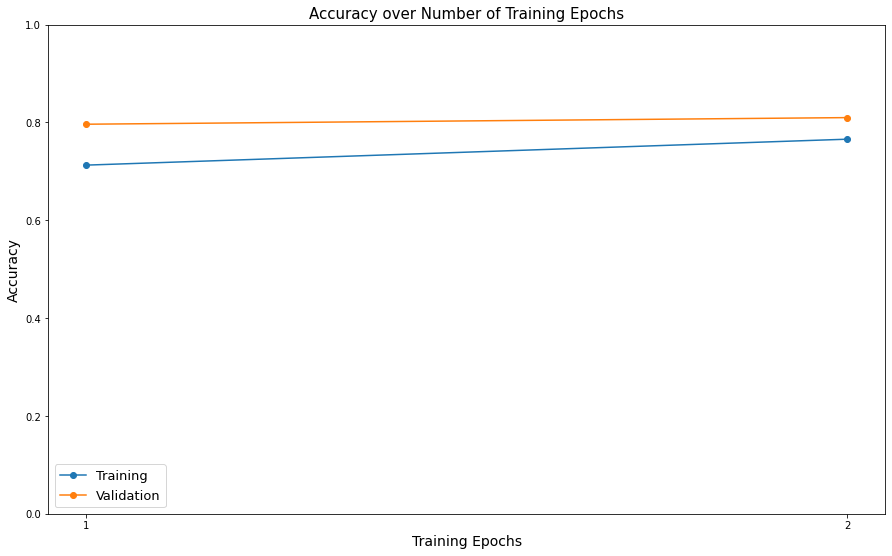

In [ ]:
visualize_acc_hist(train_history, val_history)

In [ ]:
test_labels = []
predict_labels = []

for inputs, labels in tqdm(data_loaders['val']):
  test_labels.extend(list(labels.detach().cpu().numpy()))

  inputs = inputs.to(device)
  labels = labels.to(device)

  predicted = model(inputs)
  _, preds = torch.max(predicted, 1)
  predict_labels.extend(list(preds.detach().cpu().numpy()))

print(test_labels)
print(predict_labels)

100%|██████████| 334/334 [00:26<00:00, 12.65it/s]

[9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9, 1, 4, 6, 0, 9, 3, 8, 8, 3, 3, 8, 0, 7, 5, 7, 9, 6, 1, 3, 7, 6, 7, 2, 1, 2, 2, 4, 4, 5, 8, 2, 2, 8, 4, 8, 0, 7, 7, 8, 5, 1, 1, 2, 3, 9, 8, 7, 0, 2, 6, 2, 3, 1, 2, 8, 4, 1, 8, 5, 9, 5, 0, 3, 2, 0, 6, 5, 3, 6, 7, 1, 8, 0, 1, 4, 2, 3, 6, 7, 2, 7, 8, 5, 9, 9, 4, 2, 5, 7, 0, 5, 2, 8, 6, 7, 8, 0, 0, 9, 9, 3, 0, 8, 4, 1, 5, 4, 1, 9, 1, 8, 6, 2, 1, 2, 5, 1, 0, 0, 0, 1, 6, 1, 6, 2, 2, 4, 4, 1, 4, 5, 0, 4, 7, 9, 3, 7, 2, 3, 9, 0, 9, 4, 7, 4, 2, 0, 5, 2, 1, 2, 1, 3, 0, 9, 1, 0, 9, 3, 6, 7, 9, 9, 4, 4, 7, 1, 2, 1, 6, 3, 2, 8, 3, 6, 1, 1, 0, 2, 9, 2, 4, 0, 7, 9, 8, 4, 1, 8, 4, 1, 3, 1, 6, 7, 2, 8, 5, 2, 0, 7, 7, 6, 2, 7, 0, 7, 8, 9, 2, 9, 0, 5, 1, 4, 4, 5, 6, 9, 2, 6, 8, 6, 4, 2, 2, 9, 7, 6, 5, 5, 2, 8, 5, 2, 3, 0, 4, 8, 0, 0, 6, 3, 8, 9, 6, 1, 3, 0, 2, 3, 0, 8, 3, 7, 4, 0, 1, 6, 3, 0, 6, 6, 7, 5, 4, 5, 9, 5, 6, 5, 5, 1, 9, 8, 8, 3, 3, 6, 8, 0, 0, 2, 9, 7, 7, 1, 3, 6, 4, 2, 4, 9, 1, 6, 4, 8, 2, 6, 5, 4, 6, 7, 7, 7, 3, 3, 7, 0, 

In [ ]:
show_statistics(test_labels,
                predict_labels,
                list(train_set.classes))


**** Classification Report ****
              precision    recall  f1-score   support

 T-shirt/top       0.79      0.76      0.78      1000
     Trouser       0.98      0.93      0.96      1000
    Pullover       0.80      0.70      0.75      1000
       Dress       0.78      0.78      0.78      1000
        Coat       0.70      0.71      0.71      1000
      Sandal       0.89      0.90      0.90      1000
       Shirt       0.48      0.60      0.53      1000
     Sneaker       0.88      0.89      0.88      1000
         Bag       0.97      0.91      0.94      1000
  Ankle boot       0.92      0.93      0.92      1000

    accuracy                           0.81     10000
   macro avg       0.82      0.81      0.81     10000
weighted avg       0.82      0.81      0.81     10000



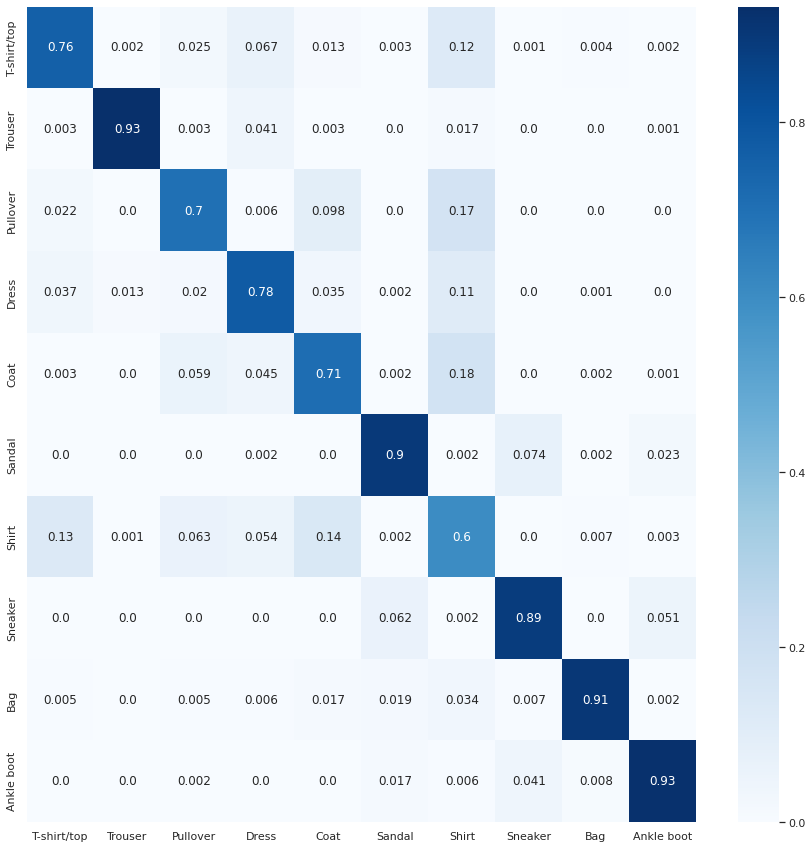

In [ ]:
plot_confusion_matrix(test_labels,
                      predict_labels,
                      list(train_set.classes))

In [ ]:
batch = next(iter(val_loader))
images, labels = batch
print(type(images), type(labels))
print(images.shape, labels.shape)

<class 'torch.Tensor'> <class 'torch.Tensor'>
torch.Size([30, 3, 299, 299]) torch.Size([30])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Labels:  Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Coat, Shirt, Sandal, Sneaker, 
Predicted:  Ankle boot, Pullover, Trouser, Trouser, Shirt, Trouser, Shirt, Shirt, Sandal, Sandal, 

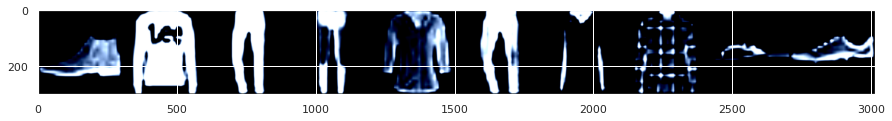

In [ ]:
grid = torchvision.utils.make_grid(images[:10], nrow=10)

plt.figure(figsize=(15, 20))
plt.imshow(np.transpose(grid, (1, 2, 0)))
print("Labels: ", end=" ")
for i, label in enumerate(labels[:10]):
  print(val_set.classes[label], end=", ")

print("\nPredicted: ", end=" ")
for i, label in enumerate(predict_labels[:10]):
  print(val_set.classes[label], end=", ")

In [ ]:
class SiameseFashionMNIST(torchvision.datasets.FashionMNIST):
  def __init__(self, *args, **kwargs):
    super(SiameseFashionMNIST, self).__init__(*args, **kwargs)
    if kwargs["train"] is True:
      self.data, self.labels = self.train_data, self.train_labels
    else:
      self.data, self.labels = self.test_data, self.test_labels

  def __getitem__(self, idx):
    x1, t1 = self.data[idx], self.labels[idx]

    is_diff = random.randint(0, 1)
    while True:
      idx2 = random.randint(0, len(self)-1)
      x2, t2 = self.data[idx2], self.labels[idx2]
      if is_diff and t1 != t2:
        break
      if not is_diff and t1 == t2:
        break

    x1, x2 = Image.fromarray(x1.numpy()), Image.fromarray(x2.numpy())
    if self.transform is not None:
      x1, x2 = self.transform(x1), self.transform(x2)
    return x1, x2, int(is_diff), t1


siamese_data_transforms = transforms.Compose([
                              transforms.ToTensor(),
                              # transforms.Normalize(mean=[0.2860347330570221],
                              #                      std=[0.3530242443084717]),
                              ])

siamese_train_loader = torch.utils.data.DataLoader(
    SiameseFashionMNIST("./data",
                        download=True,
                        train=True,
                        transform=siamese_data_transforms),
                        batch_size=batch_size,
                        shuffle=True,
                        num_workers=4)

siamese_test_loader = torch.utils.data.DataLoader(
    SiameseFashionMNIST("./data",
                        download=True,
                        train=False,
                        transform=siamese_data_transforms),
                        batch_size=batch_size,
                        shuffle=False,
                        num_workers=4)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/SiameseFashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/SiameseFashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/SiameseFashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/SiameseFashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/SiameseFashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/SiameseFashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/SiameseFashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/SiameseFashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [ ]:
class Siamese(nn.Module):
  def __init__(self):
    super(Siamese, self).__init__()
    self.c1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.c2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.c3 = nn.Conv2d(64, 128, kernel_size=3, padding=0)
    self.bn3 = nn.BatchNorm2d(128)

    self.fc4 = nn.Linear(128, 64)
    self.bn4 = nn.BatchNorm1d(64)
    self.fc5 = nn.Linear(64, 2)

  def forward(self, x):
    h = F.max_pool2d(self.bn1(self.c1(x)), 2)
    h = F.max_pool2d(self.bn2(self.c2(h)), 2)
    h = F.avg_pool2d(self.bn3(self.c3(h)), 5)

    h = self.bn4(self.fc4(h.view(h.size(0), -1)))
    return self.fc5(h)


def contractive_loss(o1, o2, y):
  g, margin = F.pairwise_distance(o1, o2), 5.0
  loss = (1 - y) * (g ** 2) + y * (torch.clamp(margin - g, min=0) ** 2)
  return torch.mean(loss)

In [ ]:
siamese_model = Siamese().cuda()

opt = optim.SGD(siamese_model.parameters(),
                lr=0.01,
                momentum=0.9)

scheduler = optim.lr_scheduler.MultiStepLR(opt, [5, 10], 0.1)
cudnn.benckmark = True

best_siamese_model_over_epochs = copy.deepcopy(siamese_model.state_dict())
best_loss = np.Inf

for e in range(2):
  scheduler.step()
  model.train()
  train_loss, train_n = 0, 0
  for x1, x2, y, label in tqdm(siamese_train_loader, total=len(siamese_train_loader), leave=False):
  # for x1, x2, y in siamese_train_loader:
    x1, x2 = Variable(x1.cuda()), Variable(x2.cuda())
    y = Variable(y.float().cuda()).view(y.size(0), 1)

    o1, o2 = siamese_model(x1), siamese_model(x2)
    loss = contractive_loss(o1, o2, y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    train_loss = loss.detach().cpu().numpy() * y.size(0)
    train_n += y.size(0)

  siamese_model.eval()
  test_loss, test_n = 0, 0
  for x1, x2, y, label in tqdm(siamese_test_loader, total=len(siamese_test_loader), leave=False):
    x1, x2 = Variable(x1.cuda()), Variable(x2.cuda())
    y = Variable(y.float().cuda()).view(y.size(0), 1)

    o1, o2 = siamese_model(x1), siamese_model(x2)
    loss = contractive_loss(o1, o2, y)
    test_loss = loss.detach().cpu().numpy() * y.size(0)
    test_n += y.size(0)
  
  if best_loss > test_loss:
    best_loss = test_loss
    best_siamese_model_over_epochs = copy.deepcopy(siamese_model.state_dict())
    
  print("\t".join(["Epoch", "TrainLoss", "TestLoss"]))
  print("{}\t{:.6f}\t{:.6f}".format(e, train_loss / train_n, test_loss / test_n))

# Load best model weights
siamese_model.load_state_dict(best_siamese_model_over_epochs)


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Epoch	TrainLoss	TestLoss
0	0.003973	0.007751


Epoch	TrainLoss	TestLoss
1	0.003874	0.010308


<All keys matched successfully>

In [ ]:
from matplotlib import offsetbox


siamese_model.eval()

inputs, embs, targets, labels = [], [], [], []
for x, x2, t, label in tqdm(siamese_test_loader, total=len(siamese_test_loader)):
# for x, x2, t in siamese_test_loader:
  x = Variable(x.cuda())
  o1 = siamese_model(x)
  inputs.extend(list(x.cpu().data.numpy()))
  embs.extend(list(o1.cpu().data.numpy()))
  targets.extend(list(t.numpy()))
  labels.extend(list(label.numpy()))

100%|██████████| 334/334 [00:02<00:00, 125.02it/s]


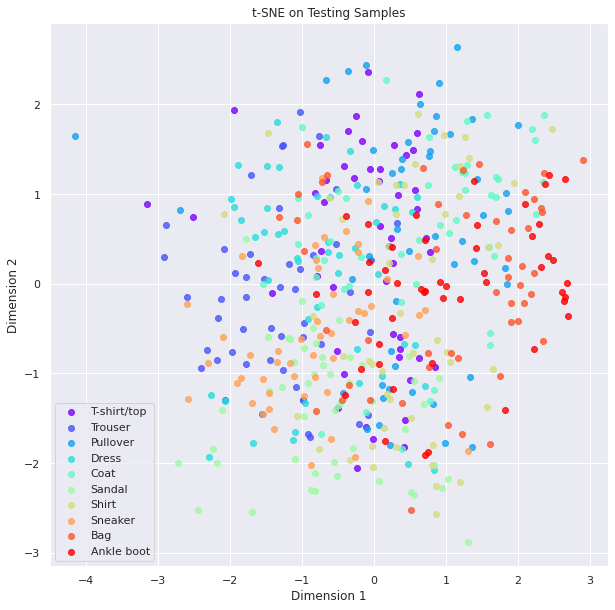

In [ ]:
val_set.classes
obj_categories = val_set.classes

colors = plt.cm.rainbow(np.linspace(0, 1, len(obj_categories)))
plt.figure(figsize=(10, 10))

embs = np.array(embs)
labels = np.array(labels)

for c_group, (c_color, c_label) in enumerate(zip(colors, obj_categories)):
  plt.scatter(embs[np.where(labels == c_group), 0].flatten()[:50],
              embs[np.where(labels == c_group), 1].flatten()[:50],
              marker='o',
              color=c_color,
              linewidth='1',
              alpha=0.8,
              label=c_label)

plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('t-SNE on Testing Samples')
plt.legend(loc='best')
plt.savefig('clothes-dist.png')
plt.show(block=False)

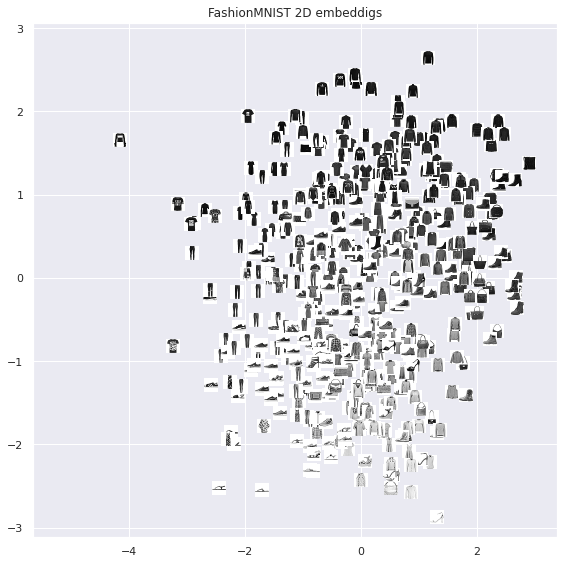

In [ ]:
n_plots = 500
plt.figure(figsize=(8, 8))
ax = plt.subplot(111)
ax.set_title("FashionMNIST 2D embeddigs")
for x, e, t in zip(inputs[:n_plots], embs[:n_plots], targets[:n_plots]):
  imagebox = offsetbox.AnnotationBbox(
    offsetbox.OffsetImage(x.squeeze(0), zoom=0.5, cmap=plt.cm.gray_r),
    xy=e, frameon=False)
  ax.add_artist(imagebox)

ax.set_xlim(embs[:, 0].min(), embs[:, 0].max())
ax.set_ylim(embs[:, 1].min(), embs[:, 1].max())
plt.tight_layout()
plt.show()